<img src="https://www.nesdis.noaa.gov/sites/default/files/assets/images/goes-r-page-logo.png" align="center" style="background-color:black;">

# GOES Lightning Detector and IR Plots

### Author: Justin Richling - The COMET Program

<br>

<div style="float:left; width:98px; height:70px">
<img src="
https://avatars2.githubusercontent.com/u/36716747?s=400&u=a525c84e0876bf9348bbb3c647d4584cd649cc3b&v=4"> 
</div>

<div style="float:right; width:150px; height:70px; background-color:black">
<img src="
https://www.meted.ucar.edu/images/logo.png"> 
</div>





#### Thanks to deeplycloudy for the ```glmtools``` package
* https://github.com/deeplycloudy/glmtools

---

## Imports
---

In [1]:
import os,glob

import numpy as np

from datetime import datetime, timedelta

from glmtools.io.glm import GLMDataset
from glmtools.test.common import get_sample_data_path
from lmatools.grid.grid_collection import LMAgridFileCollection

from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import patheffects

from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xarray as xr

## Use ```rclone``` to grab GOES netCDF files from AWS
* Good rclone setup instructions here: https://github.com/blaylockbk/pyBKB_v3/blob/master/rclone_howto.md
* My computer took ~20 minutes to get all the files
---

In [47]:
%%time
for hour in range(0,24):
    if hour < 10:
        hour = f'0{hour}'
    else:
        hour = str(hour)
    ! rclone --include "OR_GLM-L2-*s*.nc" copy Public-AWS:noaa-goes16/GLM-L2-LCFA/2020/011/{hour}/ ./GLM_Data/
    ! rclone --include "OR_ABI-L2-CMIPC-M6C13_G16_s*" copy Public-AWS:noaa-goes16/ABI-L2-CMIPC/2020/011/{hour} ./IR_Data/


CPU times: user 27.6 s, sys: 7.84 s, total: 35.4 s
Wall time: 18min 50s


### Cloud and Moisture - Meso-2

In [37]:
! rclone --include "OR_ABI-L2-CMIPM2-M6C13_G16_s*" \
copy Public-AWS:noaa-goes16/ABI-L2-CMIPM/2020/011/{HOUR}/ ./IR_Data/

^C


## Try and combine 5 1-minute files into a 5-minute file
---

In [24]:
yup1 = xr.open_dataset(glm_merged_ds[0])
yup2 = xr.open_dataset(glm_merged_ds[1])
yup3 = xr.open_dataset(glm_merged_ds[2])
yup4 = xr.open_dataset(glm_merged_ds[3])
yup5 = xr.open_dataset(glm_merged_ds[4])

In [25]:
fed_1 = yup1.flash_extent_density
fed_2 = yup2.flash_extent_density
fed_3 = yup3.flash_extent_density
fed_4 = yup4.flash_extent_density
fed_5 = yup5.flash_extent_density

In [26]:
fedz = fed_1+fed_2+fed_3+fed_4+fed_5
fedz

<xarray.DataArray 'flash_extent_density' (y: 1500, x: 2500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 -0.101331994 -0.101275995 ... 0.03855601 0.038612008
  * y        (y) float32 0.12821199 0.12815599 0.1281 ... 0.044323996 0.04426799

## Set the path for the raw and merged GLM files and the IR files
---

In [ ]:
glm_merged_path = "/Users/chowdahead/glmtools/COMET/GLM_Merged_Data/"

In [ ]:
! cd {glm_merged_path}

In [3]:
ir_path = "/Users/chowdahead/glmtools/COMET/IR_Data/"
glm_path = "/Users/chowdahead/glmtools/COMET/GLM_Data/"

## Grab the raw GLM and IR files
---

In [4]:
glm_samples = [name for name in glob.glob(f'{glm_path}/OR_GLM*LCFA*s2020011*')]
IR_samples = [name for name in glob.glob(f'{ir_path}/OR_ABI-L2*.nc')]


## glmtools split events into new netCDF files

* Doing this in Jupyter may not be the best idea, I haven't tried pure command line yet...
---

In [5]:
def events_nc(hour,minute):
    try:
        glm_samples = [name for name in glob.glob(f'{glm_path}/OR_GLM*LCFA*s2020011{hour}{minute}*')]
        #print(glm_samples,"\n")
        startdate = datetime(2020, 1, 11, int(hour), int(minute))
        duration = timedelta(0, 60*1)
        enddate = startdate+duration

        cmd = "python make_GLM_grids.py"
        cmd += " --fixed_grid --split_events --goes_position east --goes_sector conus"
        cmd += " --dx=2.0 --dy=2.0"
        cmd += " --start={1} --end={2} {0}"

        cmd = cmd.format(' '.join(glm_samples),startdate.isoformat(), enddate.isoformat())
        !{cmd}
    except:
        print("file not created...")

### This will take a lot of time!!

* Looking like ~4 hours for 1 day's worth of data! (1440 files)

In [ ]:
%%time
for hour in range(0,24):
    if hour < 10:
        hour = f'0{hour}'
    else:
        hour = str(hour)
    for i in range(0,60):
        if i < 10:
            minute=f'0{i}'
        else:
            minute = str(i)
        events_nc(hour,minute)

/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gridnonzero = (prev_values > 0)
/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gridnonzero = (prev_values > 0)
/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gridnonzero = (prev_values > 0)
/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gridnonzero = (prev_values > 0)
/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gridnonzero = (prev_values > 0)
/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gridnonzero = (prev_values > 0)
/Users/chowdahead/glmtools/glmtools/grid/accumulate.py:101: RuntimeWarning: invalid value encountered in greater
  gri

## Grab the new merged GLM files
---

In [ ]:
glm_merged_ds = glob.glob(f"{glm_merged_path}OR_GLM-L2-GLMC-*.nc")
#glm_merged_ds

## Use this code block below for IR NESDIS colorscale

* Need to download L1B Radiance files instead of Cloud and Moisture files (L2)
---

## Plot Functions
---

In [17]:
def make_1min_map(fed_index,ir_index):
    
    # Flash Extent Density data
    #-----------------------------------------
    fed_ds = Dataset(glm_merged_ds[fed_index])
    fed_data = fed_ds.variables['flash_extent_density'][:]
    
    # IR data
    #-----------------------------------------
    path = IR_samples[ir_index]
    # Open the file using the NetCDF4 library
    ir_ds = Dataset(path)
    # Extract the IR values from the NetCDF
    ir_data = ir_ds.variables['CMI'][:]
    
    # Coordinate values for plotting
    #-----------------------------------------------------------
    proj_var = fed_ds.variables['goes_imager_projection']
    #glm_x = fed_ds.variables['x'] * proj_var.perspective_point_height
    #glm_y = fed_ds.variables['y'] * proj_var.perspective_point_height
    #glm_xlim = glm_x.min(), glm_x.max()
    #glm_ylim = glm_y.min(), glm_y.max()
    
    x = fed_ds.variables['x'] * proj_var.perspective_point_height
    y = fed_ds.variables['y'] * proj_var.perspective_point_height
    glm_xlim = x.min(), x.max()
    glm_ylim = y.min(), y.max()
    
    #x = ir_ds.variables['x'] * proj_var.perspective_point_height
    #y = ir_ds.variables['y'] * proj_var.perspective_point_height
    #xlim = x.min(), x.max()
    #ylim = y.min(), y.max()
    W = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_westbound_longitude
    E = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_eastbound_longitude
    N = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_northbound_latitude
    S = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_southbound_latitude

    # Setting up plot
    #--------------------------------
    fig = plt.figure(figsize=(10,10))

    state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                        name='admin_1_states_provinces_lakes',
                                                        scale='50m', facecolor='none',
                                                        linestyle=":",linewidth=0.5)


    globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
    proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                                  satellite_height=proj_var.perspective_point_height, globe=globe)

    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines('10m', color='k',linewidth=0.5)
    ax.add_feature(state_boundaries, edgecolor='k')

    # Match the GLM grid limits, in fixed grid space
    #ax.set_xlim(glm_xlim)
    #ax.set_ylim(glm_ylim)
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    # Set a lat/lon box directly if desired
    ax.set_extent([-100,-90,25,35])

    #glm_norm = LogNorm(vmin=0.9, vmax=400)
    glm_norm = LogNorm(vmin=fed_data.min(), vmax=fed_data.max())
    #glm_cmap = get_cmap('magma')
    glm_cmap = get_cmap('nipy_spectral')
    glm_cmap = get_cmap('gnuplot2')
    glm_cmap._init()
    alphas = np.linspace(1.0, 0.05, glm_cmap.N+3)
    #alphas = np.linspace(1.0, 0.6, glm_cmap.N+3)
    glm_cmap._lut[:,-1] = alphas
    glm_cmap._lut[0,-1] = 0.0
    # Use a masked array instead of messing with colormap to get transparency
    # glm = np.ma.array(glm, mask=(glm == 0))
    # glm_alpha = .5 + glm_norm(glm)*0.5

    # Plot flash extent density
    #----------------------------------------------------------
    fed_img = ax.imshow(fed_data, extent=(x.min(), x.max(), 
                      y.min(), y.max()), origin='upper',
                      interpolation='nearest',
                      cmap=glm_cmap,zorder=100,
                       vmin=1, vmax=45)
    # cmap=glm_cmap,norm=glm_norm
    #fed_data.max()
    
    # Plot IR
    #----------------------------------------------------------
    ir_img = ax.imshow(ir_data, extent=(x.min(), x.max(), 
                      y.min(), y.max()), origin='upper',
                      interpolation='nearest',
                      cmap="Greys")
    #cmap=my_cmap
    #vmin=162.,vmax=330.

    # Set up colorbar
    #----------------------------------------------------------
    cbar = plt.colorbar(fed_img, orientation='vertical')
    # Make the colorbar position match the height of the Cartopy axes
    # Have to draw to force layout so that the ax position is correct
    posn = ax.get_position()
    cbar.ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])

    # Grab time for file name extension from GOES Ch13 File
    #------------------------------------------------------------------------------
    Time = str(datetime.strptime(ir_ds.time_coverage_start[:-6], '%Y-%m-%dT%H:%M'))
    Time = Time[0:10]+Time[11:16]
    timestamp = datetime.strptime(Time, '%Y-%m-%d%H:%M')
    file_time = timestamp.strftime('%Y_%m_%d_%H%M')
    print(file_time)

    # Save image
    #------------------------------------------------------------------------------
    plt.savefig(f"/Users/chowdahead/glmtools/COMET/{file_time}_1min_fed.png",bbox_inches="tight",dpi=180)


In [33]:
def make_5min_map(fed_index,ir_index):
    
    # Flash Extent Density data
    #-----------------------------------------
    fed_ds = Dataset(glm_merged_ds[fed_index])
    fed_data = fed_ds.variables['flash_extent_density'][:]
    
    # IR data
    #-----------------------------------------
    path = IR_samples[ir_index]
    # Open the file using the NetCDF4 library
    ir_ds = Dataset(path)
    # Extract the IR values from the NetCDF
    ir_data = ir_ds.variables['CMI'][:]
    
    # Coordinate values for plotting
    #-----------------------------------------------------------
    proj_var = fed_ds.variables['goes_imager_projection']
    #glm_x = fed_ds.variables['x'] * proj_var.perspective_point_height
    #glm_y = fed_ds.variables['y'] * proj_var.perspective_point_height
    #glm_xlim = glm_x.min(), glm_x.max()
    #glm_ylim = glm_y.min(), glm_y.max()
    
    x = fed_ds.variables['x'] * proj_var.perspective_point_height
    y = fed_ds.variables['y'] * proj_var.perspective_point_height
    glm_xlim = x.min(), x.max()
    glm_ylim = y.min(), y.max()
    
    #x = ir_ds.variables['x'] * proj_var.perspective_point_height
    #y = ir_ds.variables['y'] * proj_var.perspective_point_height
    #xlim = x.min(), x.max()
    #ylim = y.min(), y.max()
    W = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_westbound_longitude
    E = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_eastbound_longitude
    N = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_northbound_latitude
    S = ir_ds.variables['geospatial_lat_lon_extent'].geospatial_southbound_latitude

    # Setting up plot
    #--------------------------------
    fig = plt.figure(figsize=(10,10))

    state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                        name='admin_1_states_provinces_lakes',
                                                        scale='50m', facecolor='none',
                                                        linestyle=":",linewidth=0.5)


    globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
    proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                                  satellite_height=proj_var.perspective_point_height, globe=globe)

    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines('10m', color='k',linewidth=0.5)
    ax.add_feature(state_boundaries, edgecolor='k')

    # Match the GLM grid limits, in fixed grid space
    #ax.set_xlim(glm_xlim)
    #ax.set_ylim(glm_ylim)
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    # Set a lat/lon box directly if desired
    ax.set_extent([-100,-90,25,35])

    #glm_norm = LogNorm(vmin=0.9, vmax=400)
    glm_norm = LogNorm(vmin=fed_data.min(), vmax=fed_data.max())
    #glm_cmap = get_cmap('magma')
    glm_cmap = get_cmap('nipy_spectral')
    glm_cmap = get_cmap('CMRmap')
    glm_cmap._init()
    alphas = np.linspace(1.0, 0.05, glm_cmap.N+3)
    #alphas = np.linspace(1.0, 0.6, glm_cmap.N+3)
    glm_cmap._lut[:,-1] = alphas
    glm_cmap._lut[0,-1] = 0.0
    # Use a masked array instead of messing with colormap to get transparency
    # glm = np.ma.array(glm, mask=(glm == 0))
    # glm_alpha = .5 + glm_norm(glm)*0.5

    # Plot flash extent density
    #----------------------------------------------------------
    fed_img = ax.imshow(fedz, extent=(x.min(), x.max(), 
                      y.min(), y.max()), origin='upper',
                      interpolation='nearest',
                      cmap=glm_cmap,zorder=100,
                       vmin=1, vmax=fedz.max())
    # cmap=glm_cmap,norm=glm_norm
    #fed_data.max()
    
    # Plot IR
    #----------------------------------------------------------
    ir_img = ax.imshow(ir_data, extent=(x.min(), x.max(), 
                      y.min(), y.max()), origin='upper',
                      interpolation='nearest',
                      cmap="Greys")
    #cmap=my_cmap
    #vmin=162.,vmax=330.

    # Set up colorbar
    #----------------------------------------------------------
    cbar = plt.colorbar(fed_img, orientation='vertical')
    # Make the colorbar position match the height of the Cartopy axes
    # Have to draw to force layout so that the ax position is correct
    posn = ax.get_position()
    cbar.ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])

    # Grab time for file name extension from GOES Ch13 File
    #------------------------------------------------------------------------------
    Time = str(datetime.strptime(ir_ds.time_coverage_start[:-6], '%Y-%m-%dT%H:%M'))
    Time = Time[0:10]+Time[11:16]
    timestamp = datetime.strptime(Time, '%Y-%m-%d%H:%M')
    file_time = timestamp.strftime('%Y_%m_%d_%H%M')
    print(file_time)

    # Save image
    #------------------------------------------------------------------------------
    plt.savefig(f"/Users/chowdahead/glmtools/COMET/{file_time}_5min_fed.png",bbox_inches="tight",dpi=180)


In [ ]:
j = 1
for i in range(0,60):
    print(j,i)
    make_1min_map(j,i)
    j += 5

2020_01_11_0006


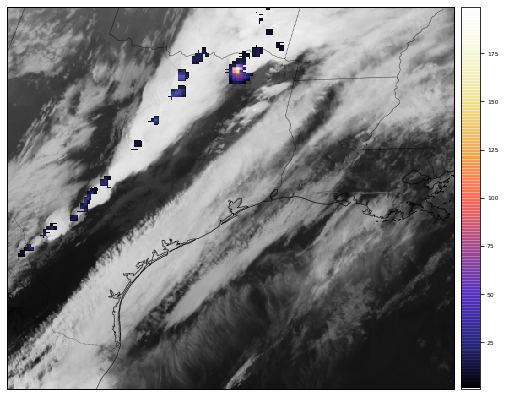

In [34]:
make_5min_map(0,1)